# Random Forest

**Imports**

In [2]:
import pandas as pd
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from pickle import dump
from sklearn import tree


/tmp/ipykernel_21782/2140849278.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


**Carga de datos**

In [3]:
url="https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv"

data=pd.read_csv(url)
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


**Realizamos un EDA completo**

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Tenemos 8 variables (todas numéricas) y la variable objetivo (1: diabetes 0: No diabetes), con un total de **768 pacientes**:

* **Pregnancies:** Número de embarazos del paciente (numérico)
* **Glucose:** Concentración de glucosa en plasma a las 2 horas de un test de tolerancia oral a la glucosa (numérico)
* **BloodPressure:** Presión arterial diastólica (medida en mm Hg) (numérico)
* **SkinThickness:** Grosor del pliegue cutáneo del tríceps (medida en mm) (numérico)
* **Insulin:** Insulina sérica de 2 horas (medida en mu U/ml) (numérico)
* **BMI:** Índice de masa corporal (numérico)
* **DiabetesPedigreeFunction:** Función de pedigrí de diabetes (numérico)
* **Age:** Edad del paciente (numérico)
* **Outcome:** Variable **objetivo** de clase (0 o 1), siendo 0 negativo en diabetes y 1, positivo (numérico)

Vamos a buscar y eliminar los duplicados y los nulos: No existen duplicados ni nulos.

In [5]:
print(data.duplicated().sum())
print(data.isnull().sum())

0
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


Exploramos las variables, distribuciones y datos atípicos:

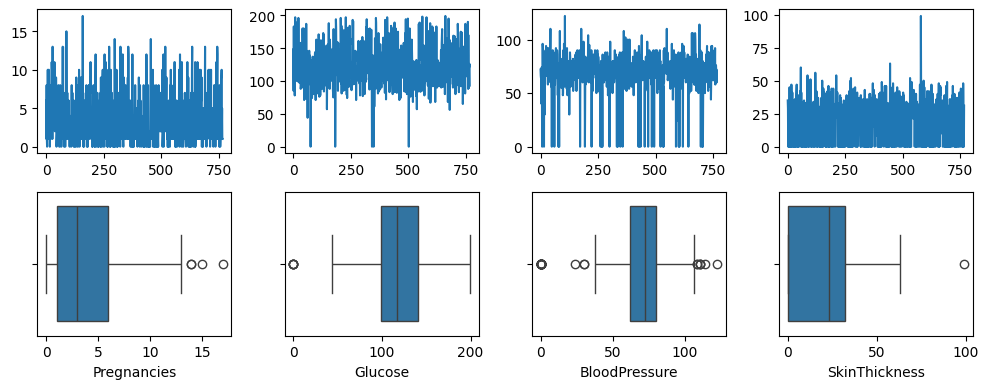

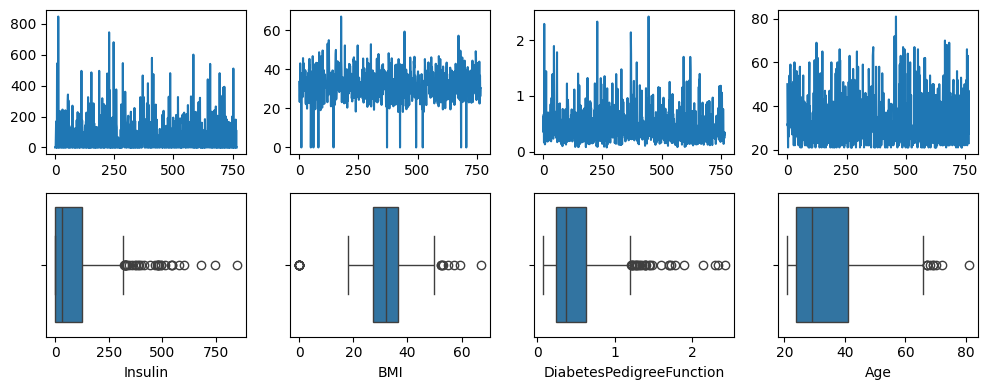

In [6]:
j=0
fig, axis= plt.subplots(2,4,figsize=(10,4))
for i in data.columns.drop("Outcome"):

    axis[0,j].plot(data[i])
    sns.boxplot(data=data,x=i,ax=axis[1,j])
    j+=1
    if j==4: 
        j=0
        plt.tight_layout()
        plt.show()
        if i!=data.columns.drop("Outcome")[len(data.columns)-2]:
            fig, axis= plt.subplots(2,4,figsize=(10,4))


Limpieza de datos atipicos: A simple vista, vemos algunos datos atípicos que probablemente sean errores en la medición: Glucosa 0, BMI 0, Blood Pressure 0. 
Vamos a ver si son los mismos pacientes para eliminarlos directamente, sino esos valores erróneos los llevaremos a la media.

También vamos a limpiar los datos de atípicos, intentando no disminuir demasiado el dataset ya que la cantidad de datos no es muy elevada:

In [7]:
Gl0=data[data["Glucose"]==0].index
BMI0=data[data["BMI"]==0].index
BP0=data[data["BloodPressure"]==0].index

union0=[x for x in Gl0 if x in BMI0 and x in BP0]

print(f"El número de pacientes con 0 en Glucosa es: {len(Gl0)}\nEl número de pacientes con 0 en BMI es:{len(BMI0)}\nEl número de pacientes con 0 en BP0 es: {len(BP0)} \nEl número de pacientes con todos los indicadores en 0 es: {len(union0)} ")

El número de pacientes con 0 en Glucosa es: 5
El número de pacientes con 0 en BMI es:11
El número de pacientes con 0 en BP0 es: 35 
El número de pacientes con todos los indicadores en 0 es: 0 


Hemos comprobado que los valores nulos en las variables Glucose, BMI y BloodPressure no coinciden en los tres casos, por tanto, alguna de las variables sí se está tomando correctamente en esos casos. Nos llevamos esos atípicos, junto con el resto a la media.

In [8]:
#Definimos una función para llevar los atípicos a la media:

def out_mean(var,inf=5,sup=95):
    
    lim_inf = np.percentile(var, inf)
    lim_sup = np.percentile(var, sup)
    outliers = (var < lim_inf) | (var > lim_sup)
    var_clean=var.copy()
    var_clean[outliers]=np.mean(var[~outliers])
    return var_clean    


Vamos a limpiar todas las variables:

/tmp/ipykernel_21782/2475393702.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.4523160762942777' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  var_clean[outliers]=np.mean(var[~outliers])
/tmp/ipykernel_21782/2475393702.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '120.56772334293949' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  var_clean[outliers]=np.mean(var[~outliers])
/tmp/ipykernel_21782/2475393702.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '71.1548480463097' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  var_clean[outliers]=np.mean(var[~outliers])
/tmp/ipykernel_21782/2475393702.py:9: Futu

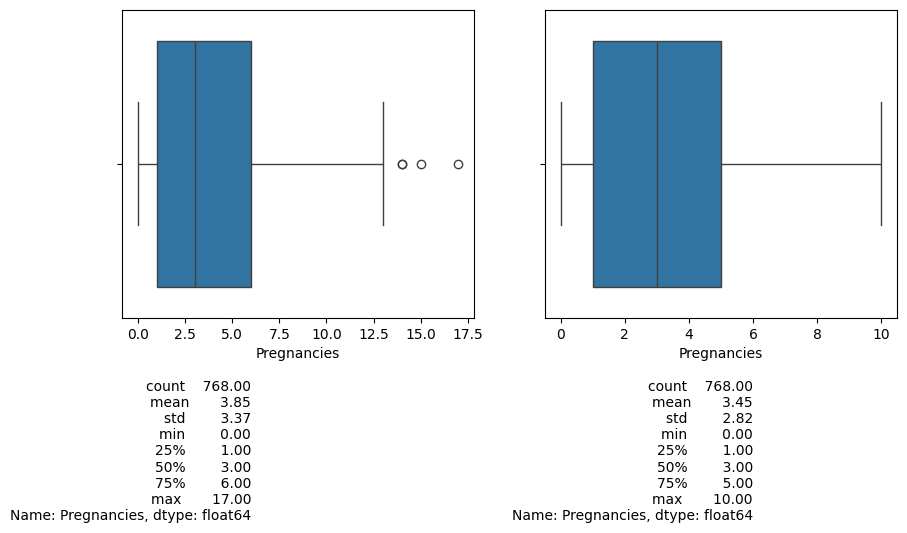

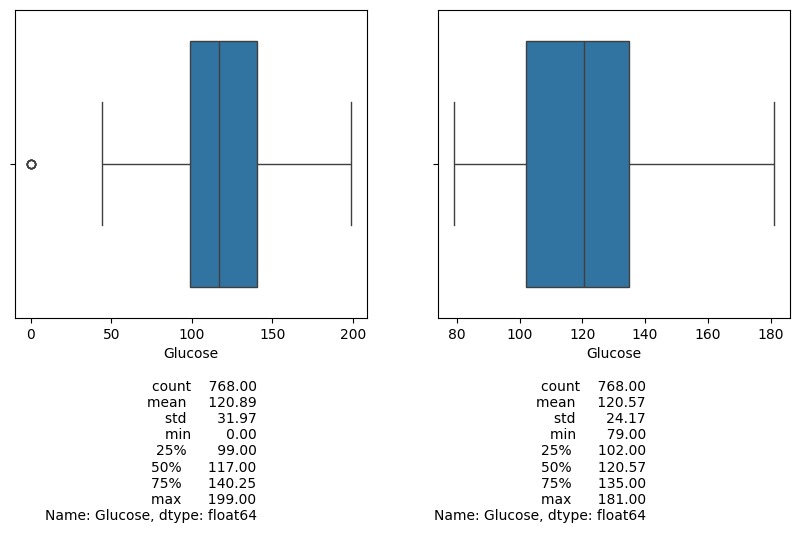

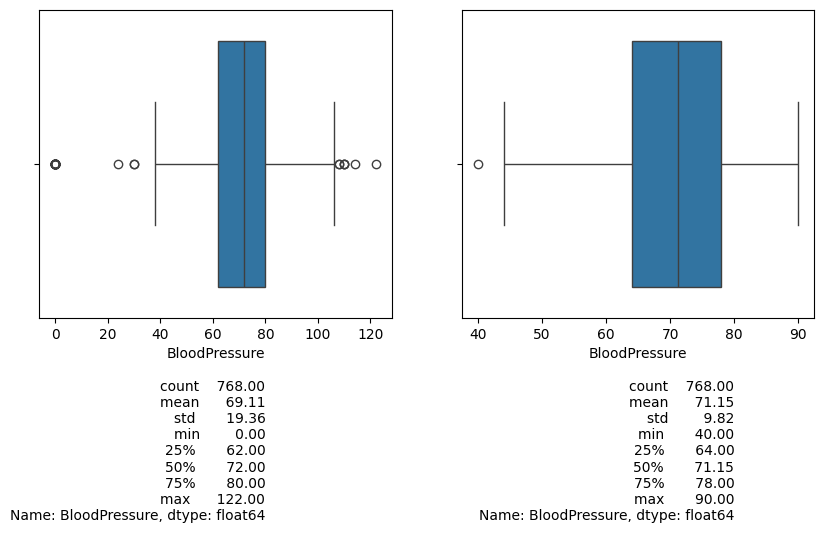

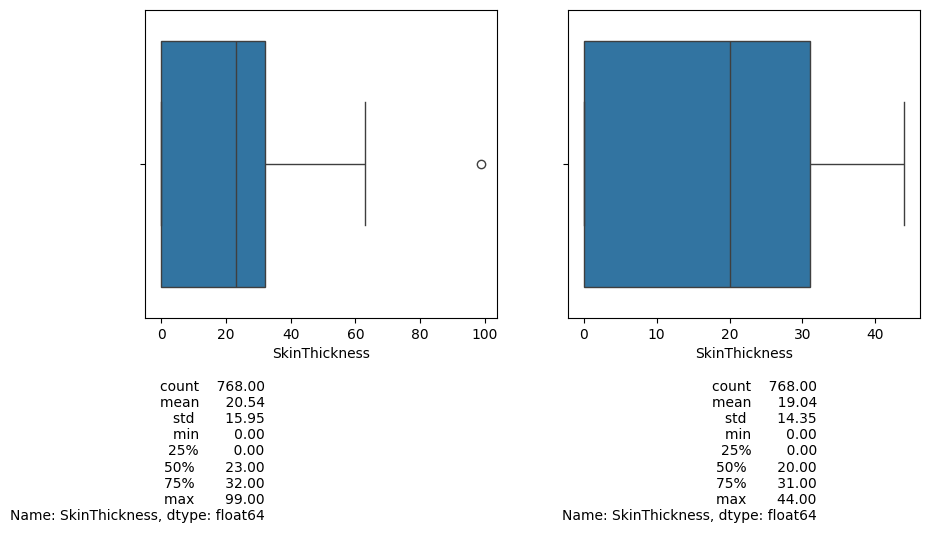

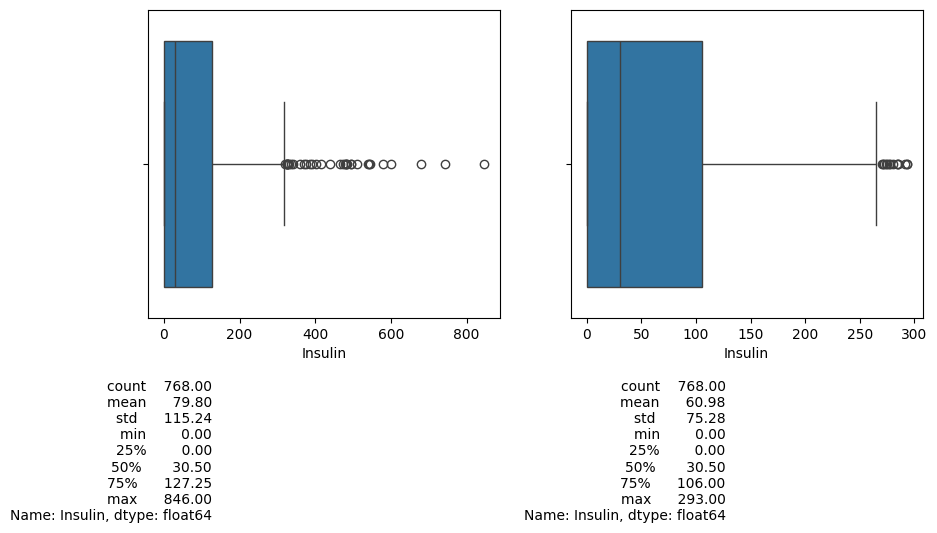

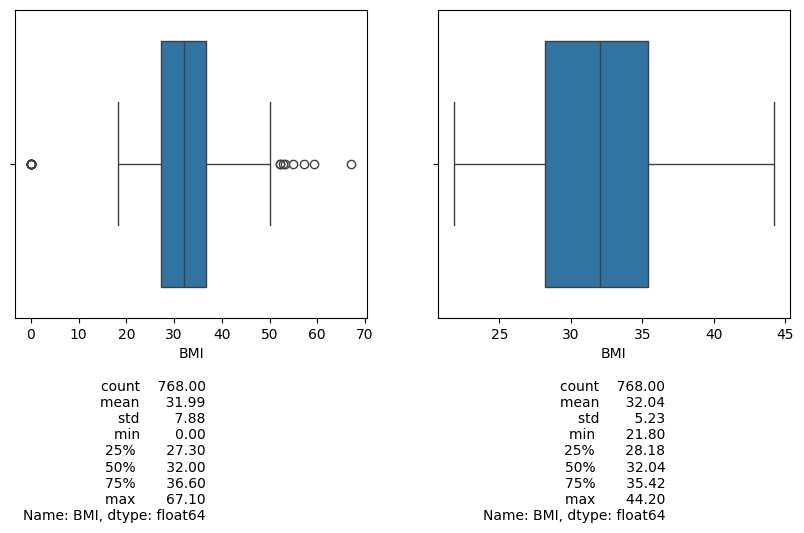

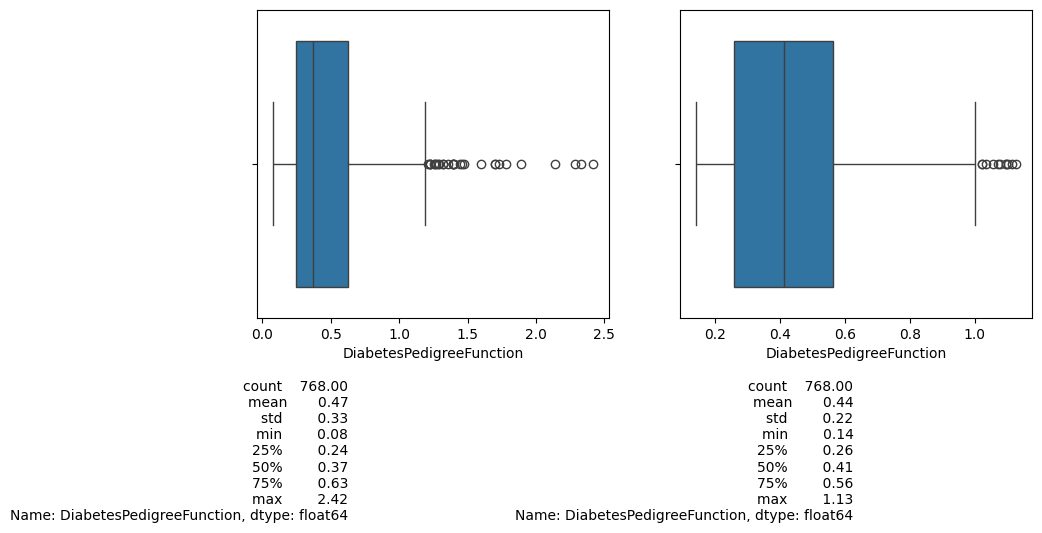

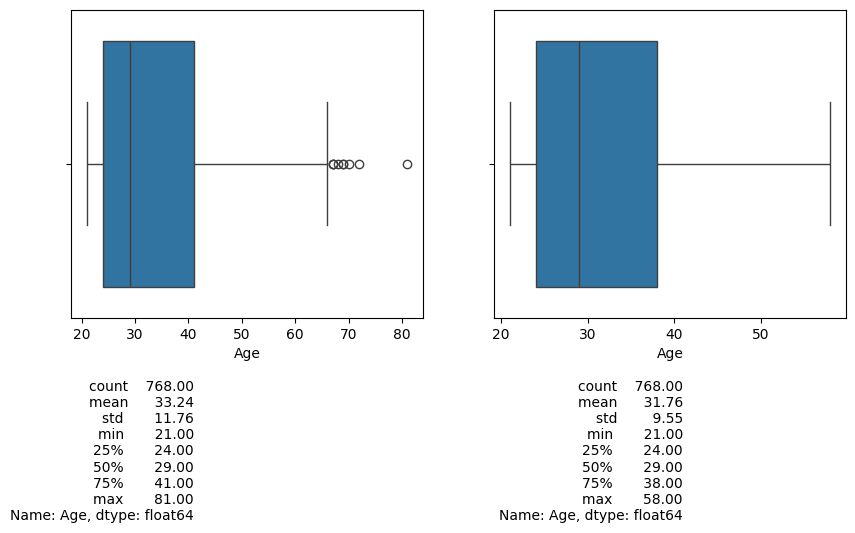

In [9]:
data_clean=pd.DataFrame()
for i in data.columns.drop("Outcome"):
    data_clean[i]=out_mean(data[i])
    fig, axis = plt.subplots(1,2,figsize=(10,4))
    sns.boxplot(x=data[i],ax=axis[0])
    x=np.percentile(data[i],75)
    sns.boxplot(x=data_clean[i],ax=axis[1])
    axis[0].text(x,0.7,round(data[i].describe(),2),fontsize=10, ha='right', va='top')
    axis[1].text(x,0.7,round(data_clean[i].describe(),2),fontsize=10, ha='right', va='top')
data_clean["Outcome"]=data["Outcome"]

Comprobamos la correlación con la variable objetivo del dataset limpio y con atípicos:

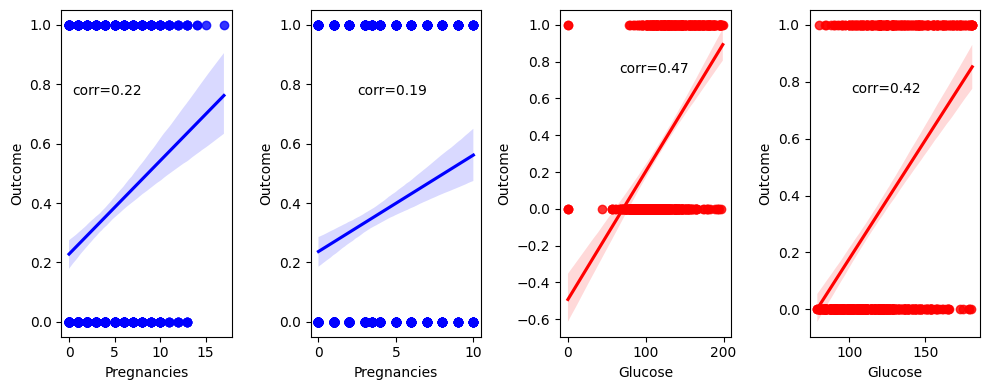

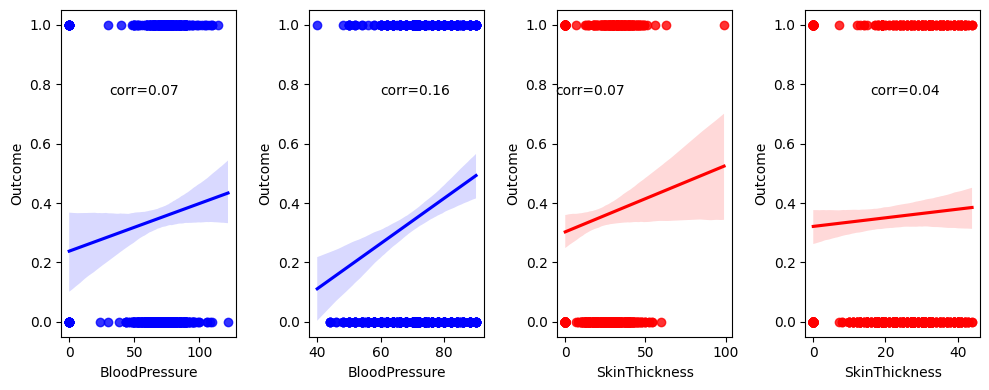

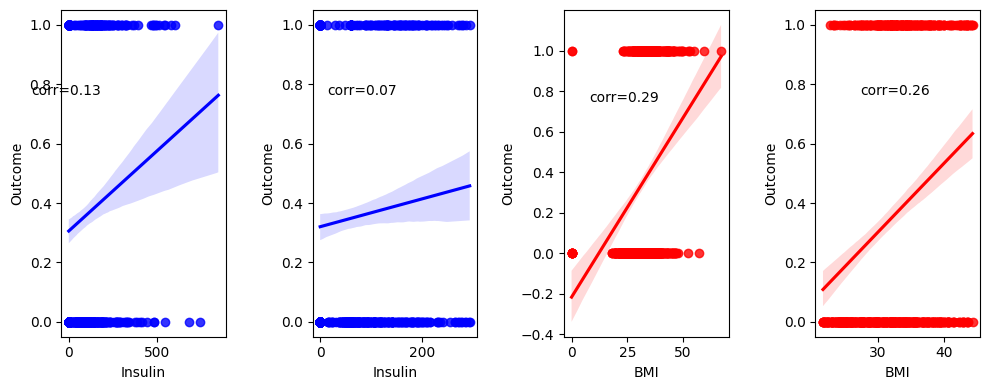

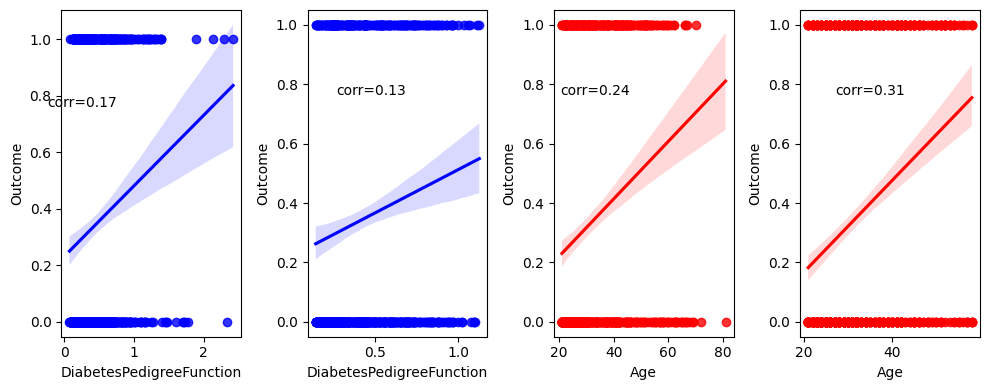

In [10]:
j=0
col="blue"
fig, axis= plt.subplots(1,4,figsize=(10,4))
for i in data.columns.drop("Outcome"):

    sns.regplot(data=data,x=i,y="Outcome",ax=axis[j],color=col)
    sns.regplot(data=data_clean,x=i,y="Outcome",ax=axis[j+1],color=col)
    x1=np.percentile(data[i],85)
    x2=np.percentile(data_clean[i],85)
    axis[j].text(x1,0.8,"corr=" + str(round(data[i].corr(data["Outcome"]),2)),fontsize=10, ha='right', va='top')
    axis[j+1].text(x2,0.8,"corr=" + str(round(data_clean[i].corr(data_clean["Outcome"]),2)),fontsize=10, ha='right', va='top')
    j+=2
    col="red"
    if j==4: 
        j=0
        col="blue"
        plt.tight_layout()
        plt.show()
        if i!=data.columns.drop("Outcome")[len(data.columns)-2]:
            fig, axis= plt.subplots(1,4,figsize=(10,4))

Como podemos ver, con la limpieza hemos disminuido la amplitud del intervalo de confianza en todos los casos.

Si quisieramos disminuir el numero de caracteristicas podríamos empezar con las variables: Insulin y Skinthickness que tienen una correlación baja con la variable objetivo. Más adelante probaremos a ver si mejora el modelo.

Como estamos con un random forest, no vamos a normalizar las variables.

Realizamos un parallel coordinates como paso final para visualizar todas las variables predictoras frente a la variable objetivo:

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'Pregnancies'),
  Text(1, 0, 'Glucose'),
  Text(2, 0, 'BloodPressure'),
  Text(3, 0, 'SkinThickness'),
  Text(4, 0, 'Insulin'),
  Text(5, 0, 'BMI'),
  Text(6, 0, 'DiabetesPedigreeFunction'),
  Text(7, 0, 'Age')])

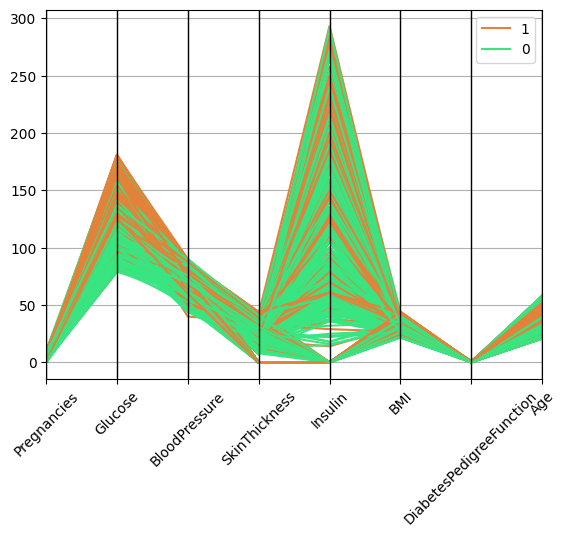

In [11]:
pd.plotting.parallel_coordinates(data_clean, "Outcome", color = ("#E58139", "#39E581"))
plt.xticks(rotation=45)

Vemos cómo la variable **Glucose** es la que más impacto tiene y la variable **Age** también puede tener impacto. Junto con las regresiones concluimos que esas variables y **BMI** son las que **mayor impacto** parecen tener en la Diabetes en este data set.

También se observa fácilmente en este gráfico que las variables **SkinThickness**, **Insulin** y **DiabetesPedigreeFunction** tienen una **correlación muy baja** con el objetivo.

Vamos a realizar un random forest para observar los resultados, con el data set completo, en primer lugar:

Separamos las muestras de entrenamiento y test:

In [12]:
X=data_clean.drop("Outcome",axis=1,inplace=False).copy()
y=data_clean["Outcome"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(X_train.info(),y_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, 60 to 102
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               614 non-null    float64
 1   Glucose                   614 non-null    float64
 2   BloodPressure             614 non-null    float64
 3   SkinThickness             614 non-null    float64
 4   Insulin                   614 non-null    float64
 5   BMI                       614 non-null    float64
 6   DiabetesPedigreeFunction  614 non-null    float64
 7   Age                       614 non-null    float64
dtypes: float64(8)
memory usage: 43.2 KB
<class 'pandas.core.series.Series'>
Index: 614 entries, 60 to 102
Series name: Outcome
Non-Null Count  Dtype
--------------  -----
614 non-null    int64
dtypes: int64(1)
memory usage: 9.6 KB
None None


**Inicialización y entrenamiento del modelo**

In [13]:
model = DecisionTreeClassifier(random_state = 42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

Visualizamos el modelo

[Text(0.4584347943722944, 0.9615384615384616, 'Glucose <= 120.284\ngini = 0.453\nsamples = 614\nvalue = [401, 213]\nclass = 0'),
 Text(0.1793831168831169, 0.8846153846153846, 'Age <= 28.5\ngini = 0.296\nsamples = 304\nvalue = [249, 55]\nclass = 0'),
 Text(0.09956709956709957, 0.8076923076923077, 'SkinThickness <= 41.5\ngini = 0.14\nsamples = 185\nvalue = [171, 14]\nclass = 0'),
 Text(0.06926406926406926, 0.7307692307692307, 'DiabetesPedigreeFunction <= 0.67\ngini = 0.114\nsamples = 181\nvalue = [170, 11]\nclass = 0'),
 Text(0.03463203463203463, 0.6538461538461539, 'Glucose <= 108.5\ngini = 0.073\nsamples = 159\nvalue = [153, 6]\nclass = 0'),
 Text(0.025974025974025976, 0.5769230769230769, 'gini = 0.0\nsamples = 115\nvalue = [115, 0]\nclass = 0'),
 Text(0.04329004329004329, 0.5769230769230769, 'DiabetesPedigreeFunction <= 0.511\ngini = 0.236\nsamples = 44\nvalue = [38, 6]\nclass = 0'),
 Text(0.025974025974025976, 0.5, 'DiabetesPedigreeFunction <= 0.142\ngini = 0.176\nsamples = 41\nvalue

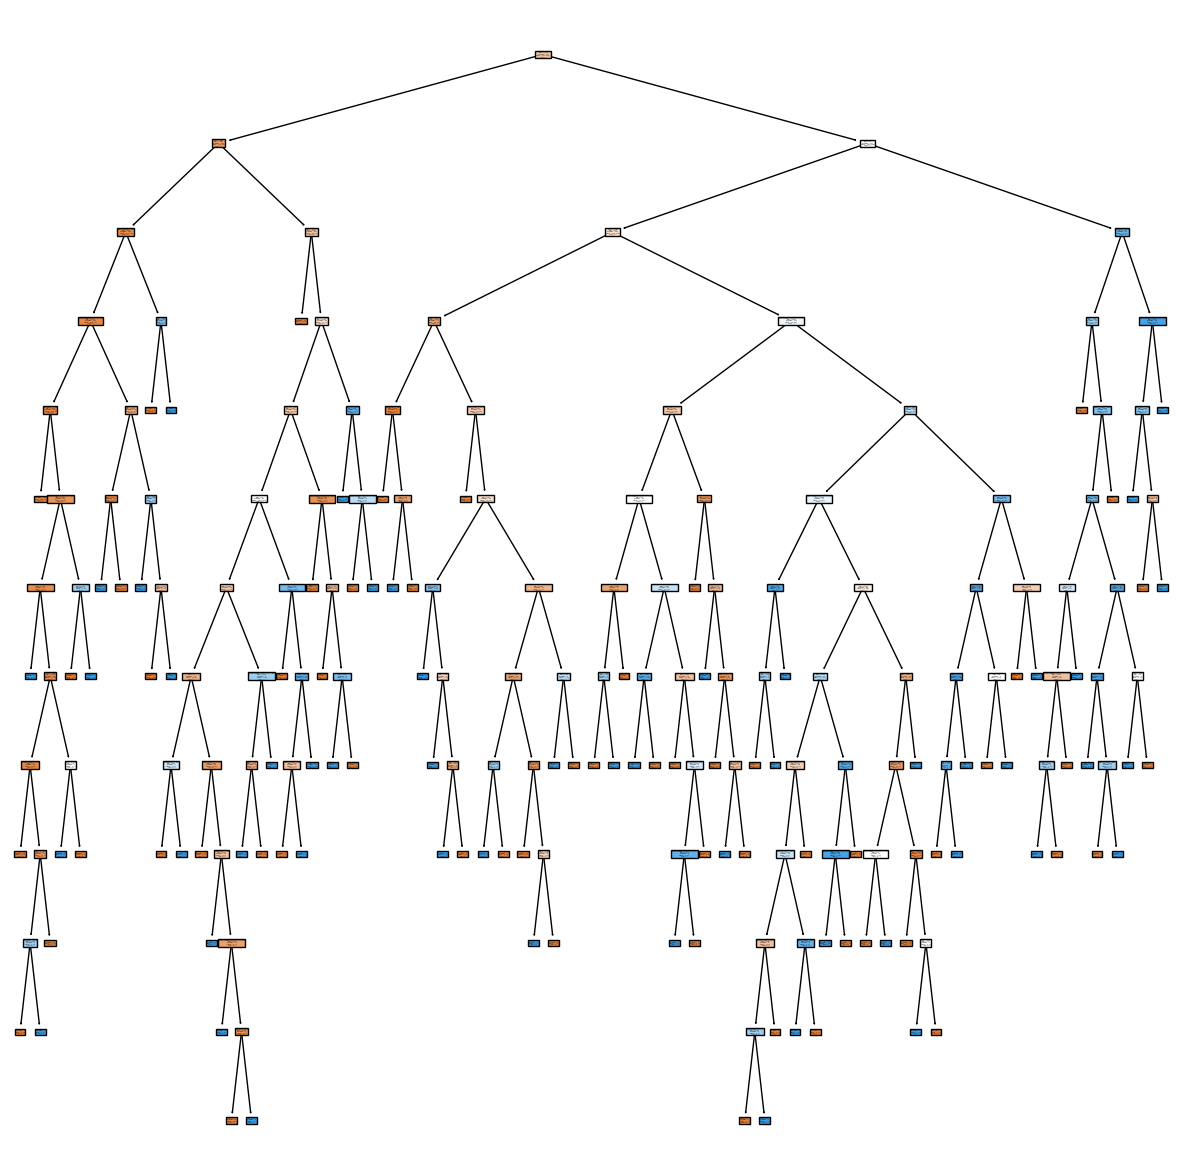

In [14]:
fig = plt.figure(figsize=(15,15))

tree.plot_tree(model, feature_names = list(X_train.columns), class_names = ["0", "1"], filled = True)


Vemos el ajuste: 

In [15]:
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.6623376623376623

Tenemos  unaccuracy del 66,23% vamos a intentar mejorarlo eliminando las variables menos correlacionadas (SkinThickness, DiabetesPedigreeFunction e Insulin)

Primero guardamos el modelo

Guardamos el modelo:

In [16]:
dump(model, open("random_forest_def_42.sav", "wb"))

Nuevo dataset sin las variables seleccionadas:

In [17]:
X2=data_clean.drop(["Outcome","SkinThickness","Insulin","DiabetesPedigreeFunction"],axis=1,inplace=False).copy()
X2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pregnancies    768 non-null    float64
 1   Glucose        768 non-null    float64
 2   BloodPressure  768 non-null    float64
 3   BMI            768 non-null    float64
 4   Age            768 non-null    float64
dtypes: float64(5)
memory usage: 30.1 KB


In [18]:
X2_train,X2_test, y2_train, y2_test= train_test_split(X2,y,train_size=0.2,random_state=42)

print(X2_train.info(),y2_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 505 to 102
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pregnancies    153 non-null    float64
 1   Glucose        153 non-null    float64
 2   BloodPressure  153 non-null    float64
 3   BMI            153 non-null    float64
 4   Age            153 non-null    float64
dtypes: float64(5)
memory usage: 7.2 KB
<class 'pandas.core.series.Series'>
Index: 153 entries, 505 to 102
Series name: Outcome
Non-Null Count  Dtype
--------------  -----
153 non-null    int64
dtypes: int64(1)
memory usage: 2.4 KB
None None


In [19]:
model2 = DecisionTreeClassifier(random_state = 42)
model2.fit(X2_train, y2_train)

DecisionTreeClassifier(random_state=42)

[Text(0.2846746575342466, 0.9642857142857143, 'Glucose <= 100.5\ngini = 0.471\nsamples = 153\nvalue = [95, 58]\nclass = 0'),
 Text(0.06164383561643835, 0.8928571428571429, 'Age <= 42.5\ngini = 0.108\nsamples = 35\nvalue = [33, 2]\nclass = 0'),
 Text(0.03424657534246575, 0.8214285714285714, 'gini = 0.0\nsamples = 31\nvalue = [31, 0]\nclass = 0'),
 Text(0.08904109589041095, 0.8214285714285714, 'Age <= 48.0\ngini = 0.5\nsamples = 4\nvalue = [2, 2]\nclass = 0'),
 Text(0.06164383561643835, 0.75, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]\nclass = 1'),
 Text(0.11643835616438356, 0.75, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]\nclass = 0'),
 Text(0.5077054794520548, 0.8928571428571429, 'BMI <= 40.7\ngini = 0.499\nsamples = 118\nvalue = [62.0, 56.0]\nclass = 0'),
 Text(0.4803082191780822, 0.8214285714285714, 'Age <= 28.5\ngini = 0.487\nsamples = 107\nvalue = [62.0, 45.0]\nclass = 0'),
 Text(0.17123287671232876, 0.75, 'Glucose <= 127.0\ngini = 0.359\nsamples = 47\nvalue = [36, 11]\nclass = 0'),
 T

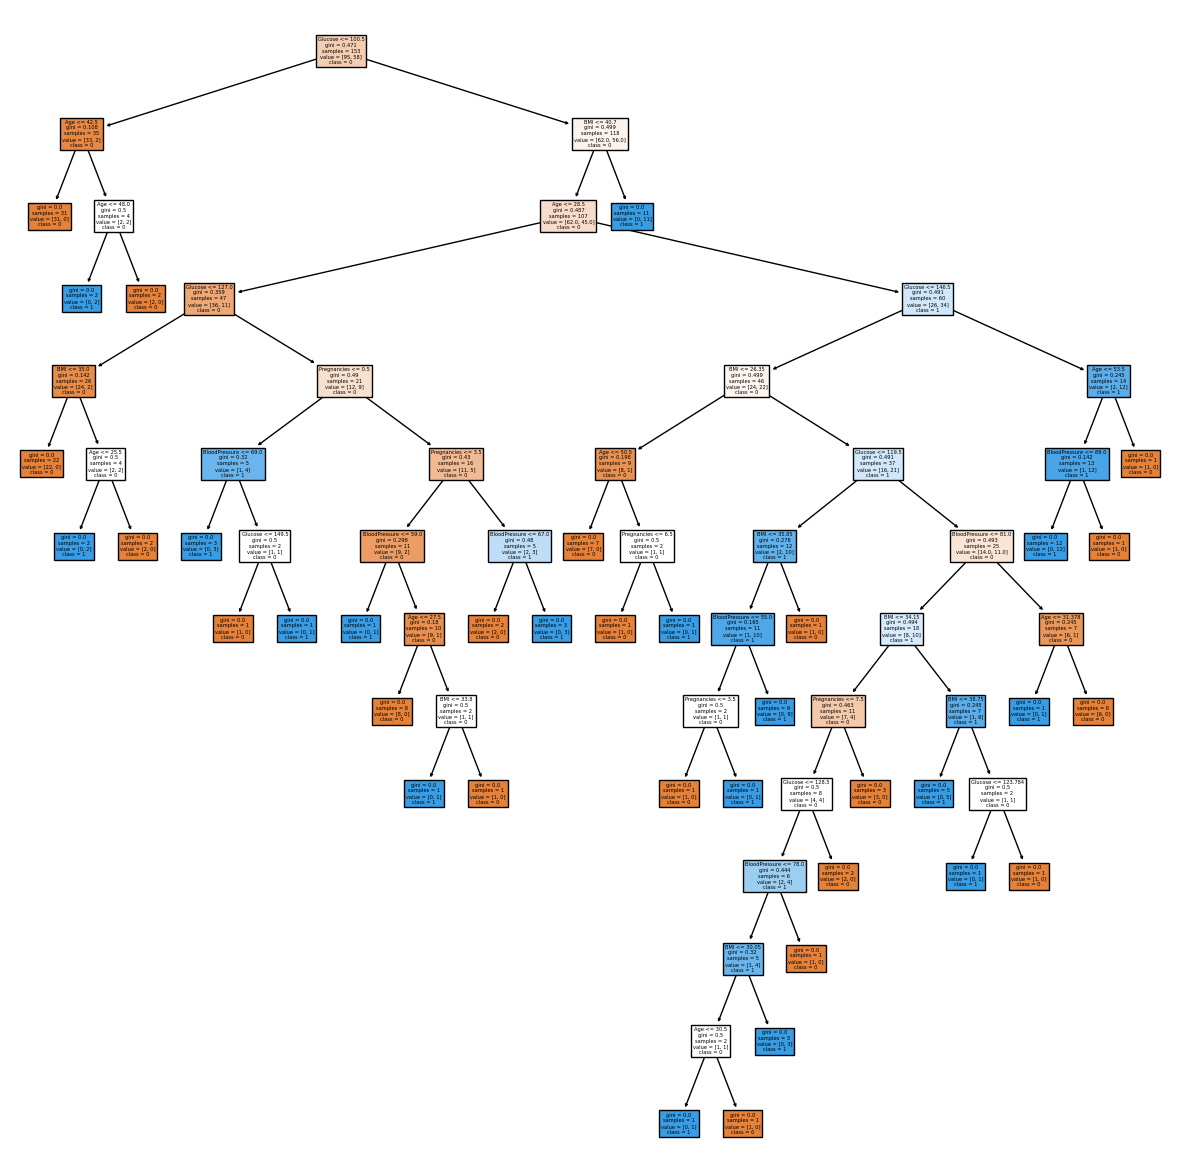

In [20]:
fig = plt.figure(figsize=(15,15))

tree.plot_tree(model2, feature_names = list(X2_train.columns), class_names = ["0", "1"], filled = True)

In [21]:
y2_pred=model2.predict(X2_test)
accuracy_score(y2_pred,y2_test)

0.6796747967479675

Con la eliminación de estas 3 variables, hemos conseguido un modelo más sencillo y con un accuracy mejor: 67,96%

Guardamos el modelo

In [22]:
dump(model2, open("random_forest_2_def_42.sav", "wb"))